<a href="https://colab.research.google.com/github/HongJieYang/Age-Gender-Emotion-Detector/blob/main/Emotion_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# VGGFace based on vgg16 architecture
from IPython.display import clear_output
!pip install keras_vggface
clear_output()

In [ ]:
# Required for VGGFace
!pip install keras_applications
clear_output()

In [ ]:
# Set up directory
import os
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
os.chdir('/content')

Mounted at /content/drive


In [ ]:
# Create local copy 
!cp "/content/drive/MyDrive/test/archive.zip" .
!unzip -q "/content/archive.zip"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from PIL import Image

In [ ]:
import shutil
folder_path = "/content/train_class"

## **Prepare Dataset for Splitting**

In [ ]:
# Remove Fear (class 005), Disgust (class 006) and Contempt (class 008)
shutil.rmtree(folder_path + "/class005")
shutil.rmtree(folder_path + "/class006")
shutil.rmtree(folder_path + "/class008")
shutil.rmtree("/content/val_class/class005")
shutil.rmtree("/content/val_class/class006")
shutil.rmtree("/content/val_class/class008")

## **Split Up Folders into Training, Validation, and Testing Datasets**

In [ ]:
!pip install split-folders
clear_output()
import splitfolders
splitfolders.ratio("/content/train_class", output="/content/output", seed=1337, ratio=(.9, .1, 0), group_prefix=None)

Copying files: 25000 files [00:04, 5011.68 files/s]


In [ ]:
# delete unwanted files or empty folders
for subdir in os.listdir(folder_path):
    subpath = os.path.join(folder_path, subdir)

    if os.path.isdir(subpath):

        if subdir[0] != "f" and subdir[0] != "m":
            shutil.rmtree(subpath)
            
    elif os.path.isfile(subpath):
        os.remove(subdir)

shutil.rmtree(folder_path)

## **Train the Model Based on Modified VGGFace Architecture**

In [ ]:
import keras
from keras.applications.vgg16 import VGG16

In [ ]:
IMAGE_SIZE = [224, 224]

train_path = "/content/output/train"
test_path = "/content/val_class"
valid_path  = "/content/output/val"

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
from glob import glob

In [ ]:
# Need to replace 'from keras.engine.topology import get_source_inputs with' 
# 'from tensorflow.keras.utils import get_source_inputs' in models.py
from keras_vggface.vggface import VGGFace

vgg_features = VGGFace(include_top=False, input_shape=(224, 224, 3), pooling='avg')

58925056/58909280 [==============================] - 3s 0us/step


In [ ]:
# Using feature extraction transfer learning, freeze base layer's parameters
for layer in vgg_features.layers:
    layer.trainable = False

print(vgg_features.summary())

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [ ]:
# Number of output classes
folders = glob('/content/output/train/*')

# Add dense and dropout layers to perform the predictions
test_model = Model(inputs=vgg_features.input, outputs=vgg_features.layers[-2].output)
x = Flatten()(test_model.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.6)(x)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=test_model.input, outputs=prediction)

print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0   

In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 22500 images belonging to 5 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 1,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 2500 images belonging to 5 classes.


In [ ]:
val_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 2500 images belonging to 5 classes.


In [ ]:
# Set up cost and optimizer 
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.00001)

model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

In [ ]:
# fit the model
# Run the cell. It will take some time to execute
p = model.fit(
  training_set,
  validation_data=val_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(val_set),
)

Epoch 1/10
704/704 [==============================] - 385s 544ms/step - loss: 1.3759 - accuracy: 0.4489 - val_loss: 1.0778 - val_accuracy: 0.5808
Epoch 2/10
704/704 [==============================] - 360s 512ms/step - loss: 1.0515 - accuracy: 0.5886 - val_loss: 0.9853 - val_accuracy: 0.6208
Epoch 3/10
704/704 [==============================] - 359s 510ms/step - loss: 0.9837 - accuracy: 0.6182 - val_loss: 0.9419 - val_accuracy: 0.6308
Epoch 4/10
704/704 [==============================] - 360s 511ms/step - loss: 0.9485 - accuracy: 0.6310 - val_loss: 0.9309 - val_accuracy: 0.6356
Epoch 5/10
704/704 [==============================] - 360s 511ms/step - loss: 0.9189 - accuracy: 0.6466 - val_loss: 0.9300 - val_accuracy: 0.6392
Epoch 6/10
704/704 [==============================] - 360s 511ms/step - loss: 0.8995 - accuracy: 0.6520 - val_loss: 0.9198 - val_accuracy: 0.6484
Epoch 7/10
704/704 [==============================] - 359s 510ms/step - loss: 0.8771 - accuracy: 0.6616 - val_loss: 0.9085 -

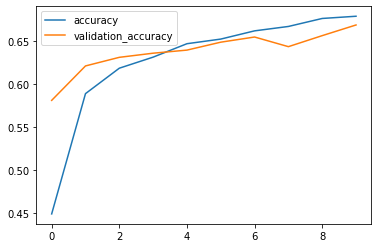

In [ ]:
plt.plot(p.history['accuracy'], label='accuracy')
plt.plot(p.history['val_accuracy'], label='validation_accuracy')
plt.legend()
plt.show()

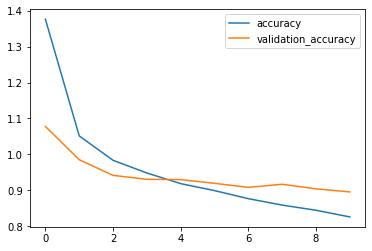

In [ ]:
plt.plot(p.history['loss'], label='accuracy')
plt.plot(p.history['val_loss'], label='validation_accuracy')
plt.legend()
plt.show()

## **Model Performance Results**

In [ ]:
# Get list of pictures from test set
filenames = test_set.filenames
num_samples = len(filenames)

In [ ]:
# Get predictions for the test set
y_pred = model.predict(test_set, steps=num_samples)
pred = np.argmax(y_pred, axis=1)

In [ ]:
# Convert one hot encoding to integer and calculate total accuracy + one off accuracy
labels = []
count = 0
neighbour = 0
for i in range(len(pred)):

  labels.append(np.argmax(test_set[i][1][0]))

  if test_set[i][1][0][pred[i]] == 1:
    count = count + 1

labels = np.asarray(labels)

In [ ]:
# Accuracy and one off accuracy
print(count)
print(count / len(pred))

1611
0.6444


In [ ]:
# Confusion matrix
confusion = tf.math.confusion_matrix(labels=labels, predictions=pred, num_classes=5).numpy()
norm_confusion = np.around(confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis], decimals=2)

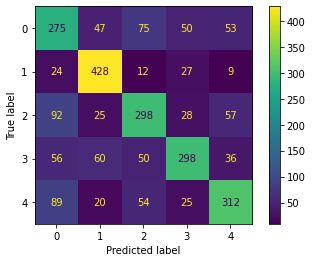

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(labels, pred)

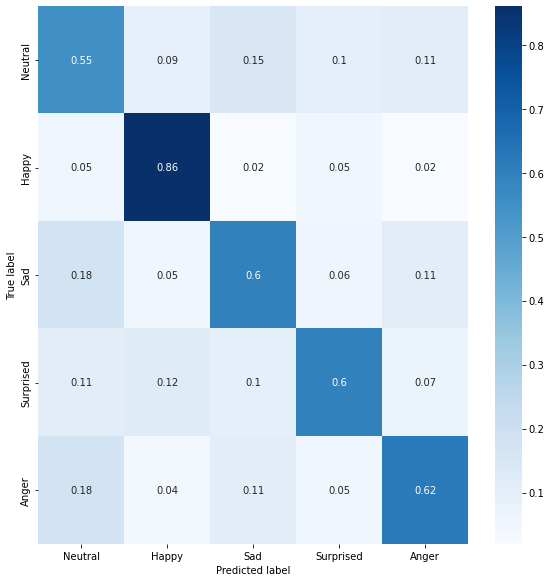

In [ ]:
# Normalized confusion matrix
classes = ["Neutral", "Happy", "Sad", "Surprised", "Anger"]
con_mat_df = pd.DataFrame(norm_confusion,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Surprised
Surprised


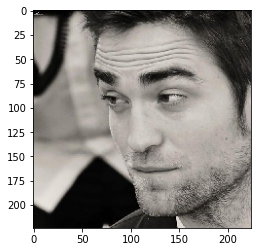

In [ ]:
# Test the model and showcase some examples
emotion_dict = {
    0: "Neutral", 
    1: "Happy", 
    2: "Sad", 
    3: "Surprised", 
    4: "Anger"
}

nums = 1707

img = test_set[nums][0]
img = np.squeeze(img)
print(emotion_dict[pred[nums]])
print(emotion_dict[np.argmax(test_set[nums][1][0])])
plt.imshow(img[:, :, :])

In [ ]:
model.save('/content/model/')

INFO:tensorflow:Assets written to: /content/model/assets


In [ ]:
# Export model as zip
os.chdir('/content/drive/MyDrive/data')
shutil.make_archive("model_emotion", "zip", "/content/model")

'/content/drive/MyDrive/data/model_emotion.zip'